<div class="alert alert-block alert-info">

## <center> <b> Stock Sentiment </center>
## <center> Predicting market behavior from tweets </center> <br>
##  <center> <b> TEST CLASSFIFIERS </center> <br>
## <center> Spring Semester 2024-2025 <center>

<center> Group 35: <center>
<center>Joana Esteves, 20240746 <br><center>
<center>José Cavaco, 20240513 <br><center>
<center> Leonardo Di Caterina 20240485<br><center>
<center>Matilde Miguel, 20240549 <br><center>
<center>Rita Serra, 20240515 <br><center>

<div>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time
import warnings
warnings.filterwarnings('ignore')

# Load data
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
data_train = pd.read_csv(os.path.join(data_folder, 'train.csv'))
print(f"Dataset shape: {data_train.shape}")
print(f"Label distribution:\n{data_train['label'].value_counts()}")
data_train.head()

Dataset shape: (9543, 2)
Label distribution:
label
2    6178
1    1923
0    1442
Name: count, dtype: int64


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


## Setup and Import Classification Module

In [2]:
print("Current working directory:", os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))
print("Changed working directory to:", os.getcwd())

from src.classification import SklearnSentimentClassifier, KerasSentimentClassifier
from src.embedding import TextEmbedder
from src.preprocessing import Preprocessing
from imblearn.combine import SMOTETomek

print("Modules imported successfully")

Current working directory: /Users/leonardodicaterina/Desktop/NovaIMS/TextMining/TM_Project/Notebooks
Changed working directory to: /Users/leonardodicaterina/Desktop/NovaIMS/TextMining/TM_Project
Modules imported successfully


## Data Preparation


In [3]:
# Use a larger subset for classification testing
subset_size = 2000
sample_data = data_train.sample(n=subset_size, random_state=42)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    sample_data['text'], sample_data['label'], 
    test_size=0.2, stratify=sample_data['label'], random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training label distribution:\n{pd.Series(y_train).value_counts()}")

Training set size: 1600
Test set size: 400
Training label distribution:
label
2    1031
1     330
0     239
Name: count, dtype: int64


## Generate Embeddings for Classification

In [4]:
# We'll use the best performing embedding from your previous analysis
print("Generating embeddings...")

# Use SentenceTransformer for high-quality embeddings
embedder = TextEmbedder(method='transformer', model_name='sentence-transformers/all-MiniLM-L6-v2')
embedder.fit(X_train.tolist())

X_train_embeddings = embedder.transform(X_train.tolist())
X_test_embeddings = embedder.transform(X_test.tolist())

print(f"Embedding shape: {X_train_embeddings.shape}")
print(f"Embedding dimension: {X_train_embeddings.shape[1]}")

Generating embeddings...
Embedding shape: (1600, 384)
Embedding dimension: 384


### Balance Dataset


In [5]:
# Apply SMOTE-Tomek for better class balance
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_embeddings, y_train)

#X_train_balanced = np.clip(X_train_balanced, 0, None)  # Clips to [0, inf]
X_train_balanced = np.clip(X_train_balanced, 1e-8, None)

print(f"Original training set size: {len(X_train_embeddings)}")
print(f"Balanced training set size: {len(X_train_balanced)}")
print(f"Balanced label distribution:\n{pd.Series(y_train_balanced).value_counts()}")
print(f"Min value after clipping: {X_train_balanced.min()}")
print(f"Max value after clipping: {X_train_balanced.max()}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Original training set size: 1600
Balanced training set size: 3087
Balanced label distribution:
label
0    1030
1    1029
2    1028
Name: count, dtype: int64
Min value after clipping: 9.99999993922529e-09
Max value after clipping: 0.24581165611743927


## Performance Testing


In [6]:
sklearn_configs = [
    {
        'name': 'Logistic Regression',
        'model_type': 'logistic_regression',
        'params': {'C': 1.0, 'max_iter': 1000}
    },
    {
        'name': 'Random Forest',
        'model_type': 'random_forest',
        'params': {'n_estimators': 100, 'max_depth': 10}
    },
    {
        'name': 'SVM (RBF)',
        'model_type': 'svm',
        'params': {'C': 1.0, 'kernel': 'rbf', 'gamma': 'scale'}
    },
    {
        'name': 'SVM (Linear)',
        'model_type': 'svm',
        'params': {'C': 1.0, 'kernel': 'linear'}
    },
    {
        'name': 'Naive Bayes',
        'model_type': 'naive_bayes',
        'params': {}
    }
]

keras_configs = [
    {
        'name': 'Neural Network (Small)',
        'params': {
            'hidden_layers': [64, 32],
            'dropout_rate': 0.3,
            'learning_rate': 0.001}
    },
    {
        'name': 'Neural Network (Medium)',
        'params': {
            'hidden_layers': [128, 64, 32],
            'dropout_rate': 0.4,
            'learning_rate': 0.001
        }
    },
    {
        'name': 'Neural Network (Large)',
        'params': {
            'hidden_layers': [256, 128, 64, 32],
            'dropout_rate': 0.5,
            'learning_rate': 0.0001
        }
    }
]

print(f"Configured {len(sklearn_configs)} Sklearn classifiers")
print(f"Configured {len(keras_configs)} Keras classifiers")

Configured 5 Sklearn classifiers
Configured 3 Keras classifiers


###  Sklearn Classifiers

In [ ]:
sklearn_results = []
sklearn_models = {}

print(" Testing Sklearn Classifiers...")
print("=" * 50)

for config in sklearn_configs:
    print(f"\nTesting {config['name']}...")
    
    try:
        # Initialize classifier
        classifier = SklearnSentimentClassifier(
            model_type=config['model_type'], 
            **config['params']
        )
        
        # Prepare labels
        y_train_encoded = classifier.prepare_labels(pd.Series(y_train_balanced))
        y_test_encoded = classifier.transform_labels(pd.Series(y_test))
        
        # Time training
        start_time = time.time()
        classifier.train(X_train_balanced, y_train_encoded)
        train_time = time.time() - start_time
        
        # Time prediction
        start_time = time.time()
        predictions = classifier.predict(X_test_embeddings)
        predict_time = time.time() - start_time
        
        # Evaluate
        results = classifier.evaluate(X_test_embeddings, y_test_encoded)
        #print(f"    Training time: {train_time:.2f}s, Prediction time: {predict_time:.2f}s")
        # Cross-validate
        cv_results = classifier.cross_validate(X_train_balanced, y_train_encoded, cv=5)
        #print(f"    Cross-validation results: {cv_results}")
        # Store results
        #  Cross-validation results: {'avg_accuracy': 0.8101781771071004, 'std_accuracy': 0.011812919617584289, 'avg_macro_precision': 0.8108531193893518, 'std_macro_precision': 0.012140911380330813, 'avg_macro_recall': 0.8101539190149183, 'std_macro_recall': 0.011797729006132957, 'avg_macro_f1': 0.8098225563459651, 'std_macro_f1': 0.011571176868876723, 'avg_weighted_precision': 0.810869772171373, 'std_weighted_precision': 0.012149372527066134, 'avg_weighted_recall': 0.8101781771071004, 'std_weighted_recall': 0.011812919617584289, 'avg_weighted_f1': 0.8098424912314535, 'std_weighted_f1': 0.011582309538732237, 'avg_class_0_precision': 0.8274472663744922, 'std_class_0_precision': 0.018712841737618984, 'avg_class_0_recall': 0.845631067961165, 'std_class_0_recall': 0.04750341678728185, 'avg_class_0_f1': 0.8353328455305451, 'std_class_0_f1': 0.01855441702644702, 'avg_class_1_precision': 0.8106401554993281, 'std_class_1_precision': 0.027268220031106516, 'avg_class_1_recall': 0.7890977977740943, 'std_class_1_recall': 0.017755684087261733, 'avg_class_1_f1': 0.7993176612111761, 'std_class_1_f1': 0.013753816284774916, 'avg_class_2_precision': 0.7944719362942346, 'std_class_2_precision': 0.013295198485727135, 'avg_class_2_recall': 0.7957328913094956, 'std_class_2_recall': 0.024644360838939935, 'avg_class_2_f1': 0.7948171622961739, 'std_class_2_f1': 0.01273111894019734}

        sklearn_results.append({
            'Method': config['name'],
            'Model Type': config['model_type'],
            'Accuracy': results['accuracy'],
            'CV Mean accuracy': cv_results['avg_accuracy'],
            'CV Mean precision': cv_results['avg_macro_precision'],
            'CV Mean recall': cv_results['avg_macro_recall'],
            'CV Mean F1': cv_results['avg_macro_f1'],
            
            'CV Std accuracy': cv_results['std_accuracy'],
            'CV Std precision': cv_results['std_macro_precision'],
            'CV Std recall': cv_results['std_macro_recall'],
            'CV Std F1': cv_results['std_macro_f1'],
            'Training Time (s)': train_time,
            'Prediction Time (s)': predict_time
        })
        
        # Store model for later analysis
        sklearn_models[config['name']] = {
            'classifier': classifier,
            'predictions': predictions,
            'results': results
        }
        
        #print(f"    Success - Accuracy: {results['accuracy']:.3f}, CV: {cv_results['mean_score']:.3f} ± {cv_results['std_score']:.3f}")
        print(f"    Success! \n\t- Mean accuracy: {sklearn_results[-1]['CV Mean accuracy']:.4f} ± {sklearn_results[-1]['CV Std accuracy']:.4f}, "
              f"\n\t- Mean precision: {sklearn_results[-1]['CV Mean precision']:.4f} ± {sklearn_results[-1]['CV Std precision']:.4f}, "
              f"\n\t- Mean recall: {sklearn_results[-1]['CV Mean recall']:.4f} ± {sklearn_results[-1]['CV Std recall']:.4f}, "
              f"\n\t- Mean F1: {sklearn_results[-1]['CV Mean F1']:.4f} ± {sklearn_results[-1]['CV Std F1']:.4f}")
        
    except Exception as e:
        print(f"    Failed: {str(e)}")
        sklearn_results.append({
            'Method': config['name'],
            'Error': str(e)
        })

# Create results DataFrame
sklearn_df = pd.DataFrame(sklearn_results)
print("\n📊 Sklearn Classifier Results:")
print(sklearn_df.round(4))

 Testing Sklearn Classifiers...

Testing Logistic Regression...
Sklearn logistic_regression model trained successfully.


100%|██████████| 5/5 [00:00<00:00,  9.04it/s]


    Success! 
	- Mean accuracy0.8102 ± 0.0118, 
	- Mean precision: 0.8109 ± 0.0121, 
	- Mean recall: 0.8102 ± 0.0118, 
	- Mean F1: 0.8098 ± 0.0116

Testing Random Forest...
Sklearn random_forest model trained successfully.


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


    Success! 
	- Mean accuracy0.9119 ± 0.0154, 
	- Mean precision: 0.9120 ± 0.0156, 
	- Mean recall: 0.9118 ± 0.0154, 
	- Mean F1: 0.9115 ± 0.0156

Testing SVM (RBF)...
Sklearn svm model trained successfully.


100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


    Success! 
	- Mean accuracy0.9310 ± 0.0043, 
	- Mean precision: 0.9320 ± 0.0039, 
	- Mean recall: 0.9310 ± 0.0043, 
	- Mean F1: 0.9311 ± 0.0043

Testing SVM (Linear)...
Sklearn svm model trained successfully.


100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


    Success! 
	- Mean accuracy0.8264 ± 0.0133, 
	- Mean precision: 0.8270 ± 0.0132, 
	- Mean recall: 0.8263 ± 0.0133, 
	- Mean F1: 0.8260 ± 0.0133

Testing Naive Bayes...
Sklearn naive_bayes model trained successfully.


100%|██████████| 5/5 [00:00<00:00, 27.44it/s]


    Success! 
	- Mean accuracy0.7159 ± 0.0102, 
	- Mean precision: 0.7185 ± 0.0100, 
	- Mean recall: 0.7159 ± 0.0102, 
	- Mean F1: 0.7161 ± 0.0100

📊 Sklearn Classifier Results:
                Method           Model Type  Accuracy  CV Mean accuracy  \
0  Logistic Regression  logistic_regression    0.2525            0.8102   
1        Random Forest        random_forest    0.7050            0.9119   
2            SVM (RBF)                  svm    0.6450            0.9310   
3         SVM (Linear)                  svm    0.2600            0.8264   
4          Naive Bayes          naive_bayes    0.2975            0.7159   

   CV Mean precision  CV Mean recall  CV Mean F1  CV Std accuracy  \
0             0.8109          0.8102      0.8098           0.0118   
1             0.9120          0.9118      0.9115           0.0154   
2             0.9320          0.9310      0.9311           0.0043   
3             0.8270          0.8263      0.8260           0.0133   
4             0.7185      

In [8]:
sklearn_df

,Method,Model Type,Accuracy,CV Mean accuracy,CV Mean precision,CV Mean recall,CV Mean F1,CV Std accuracy,CV Std precision,CV Std recall,CV Std F1,Training Time (s),Prediction Time (s)
0,Logistic Regression,logistic_regression,0.2525,0.810178,0.810853,0.810154,0.809823,0.011813,0.012141,0.011798,0.011571,0.180007,0.001742
1,Random Forest,random_forest,0.7050,0.911884,0.912027,0.911838,0.911477,0.015369,0.015622,0.015369,0.015561,1.300886,0.004960
2,SVM (RBF),svm,0.6450,0.931002,0.931979,0.930980,0.931114,0.004285,0.003891,0.004298,0.004306,2.831848,0.096844
3,SVM (Linear),svm,0.2600,0.826377,0.826991,0.826345,0.826028,0.013338,0.013176,0.013319,0.013337,2.385568,0.054290
4,Naive Bayes,naive_bayes,0.2975,0.715908,0.718529,0.715884,0.716108,0.010203,0.009955,0.010194,0.010005,0.007121,0.002072


### Keras Classifiers

In [9]:
keras_results = []
keras_models = {}

print("\n Testing Keras Neural Networks...")
print("=" * 50)

for config in keras_configs:
    print(f"\nTesting {config['name']}...")
    
    try:
        # Initialize classifier
        classifier = KerasSentimentClassifier(**config['params'])
        
        # Prepare labels
        y_train_encoded = classifier.prepare_labels(pd.Series(y_train_balanced))
        y_test_encoded = classifier.transform_labels(pd.Series(y_test))
        
        # Split training data for validation
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_balanced, y_train_encoded, test_size=0.2, random_state=42
        )
        
        # Time training
        start_time = time.time()
        history = classifier.train(
            X_train_split, y_train_split,
            X_val=X_val_split, y_val=y_val_split,
            epochs=50, batch_size=32, verbose=0
        )
        train_time = time.time() - start_time
        
        # Time prediction
        start_time = time.time()
        predictions = classifier.predict(X_test_embeddings)
        predict_time = time.time() - start_time
        
        # Evaluate
        results = classifier.evaluate(X_test_embeddings, y_test_encoded)
        
        # Store results
        keras_results.append({
            'Method': config['name'],
            'Hidden Layers': str(config['params']['hidden_layers']),
            'Accuracy': results['accuracy'],
            'Test Loss': results['test_loss'],
            'Train Time (s)': train_time,
            'Predict Time (s)': predict_time,
            'Total Time (s)': train_time + predict_time,
            'Epochs Trained': len(history.history['loss']),
            'Parameters': classifier.model.count_params()
        })
        
        # Store model for later analysis
        keras_models[config['name']] = {
            'classifier': classifier,
            'predictions': predictions,
            'results': results,
            'history': history
        }
        
        print(f"     Success - Accuracy: {results['accuracy']:.3f}, Loss: {results['test_loss']:.3f}")
        
    except Exception as e:
        print(f"     Failed: {str(e)}")
        keras_results.append({
            'Method': config['name'],
            'Error': str(e)
        })

# Create results DataFrame
keras_df = pd.DataFrame(keras_results)
print("\n Keras Classifier Results:")
print(keras_df.round(4))


 Testing Keras Neural Networks...

Testing Neural Network (Small)...


Neural network trained successfully for 19 epochs.
     Success - Accuracy: 0.237, Loss: 6.964

Testing Neural Network (Medium)...


Neural network trained successfully for 27 epochs.
     Success - Accuracy: 0.250, Loss: 7.722

Testing Neural Network (Large)...
Neural network trained successfully for 50 epochs.
     Success - Accuracy: 0.242, Loss: 2.552

 Keras Classifier Results:
                    Method       Hidden Layers  Accuracy  Test Loss  \
0   Neural Network (Small)            [64, 32]    0.2375     6.9644   
1  Neural Network (Medium)       [128, 64, 32]    0.2500     7.7219   
2   Neural Network (Large)  [256, 128, 64, 32]    0.2425     2.5521   

   Train Time (s)  Predict Time (s)  Total Time (s)  Epochs Trained  \
0          1.6994            0.0586          1.7580              19   
1          2.3577            0.0525          2.4102              27   
2          6.7132            0.1211          6.8344              50   

   Parameters  
0       28611  
1       62019  
2      145219  


In [10]:
sklearn_df

,Method,Model Type,Accuracy,CV Mean accuracy,CV Mean precision,CV Mean recall,CV Mean F1,CV Std accuracy,CV Std precision,CV Std recall,CV Std F1,Training Time (s),Prediction Time (s)
0,Logistic Regression,logistic_regression,0.2525,0.810178,0.810853,0.810154,0.809823,0.011813,0.012141,0.011798,0.011571,0.180007,0.001742
1,Random Forest,random_forest,0.7050,0.911884,0.912027,0.911838,0.911477,0.015369,0.015622,0.015369,0.015561,1.300886,0.004960
2,SVM (RBF),svm,0.6450,0.931002,0.931979,0.930980,0.931114,0.004285,0.003891,0.004298,0.004306,2.831848,0.096844
3,SVM (Linear),svm,0.2600,0.826377,0.826991,0.826345,0.826028,0.013338,0.013176,0.013319,0.013337,2.385568,0.054290
4,Naive Bayes,naive_bayes,0.2975,0.715908,0.718529,0.715884,0.716108,0.010203,0.009955,0.010194,0.010005,0.007121,0.002072


## Performance Visualization with Additional Metrics

 Debugging DataFrame structures:

Sklearn DataFrame columns: ['Method', 'Model Type', 'Accuracy', 'CV Mean accuracy', 'CV Mean precision', 'CV Mean recall', 'CV Mean F1', 'CV Std accuracy', 'CV Std precision', 'CV Std recall', 'CV Std F1', 'Training Time (s)', 'Prediction Time (s)']
Sklearn DataFrame shape: (5, 13)

Keras DataFrame columns: ['Method', 'Hidden Layers', 'Accuracy', 'Test Loss', 'Train Time (s)', 'Predict Time (s)', 'Total Time (s)', 'Epochs Trained', 'Parameters']
Keras DataFrame shape: (3, 9)

 Successful models found:
   • Sklearn models: 5
   • Keras models: 3

Debugging data collection:
Sklearn - Methods: 5, Accuracies: 5, Times: 5
Keras - Methods: 3, Accuracies: 3, Times: 3
Final lengths - Methods: 8, Accuracies: 8, Times: 8, Colors: 8


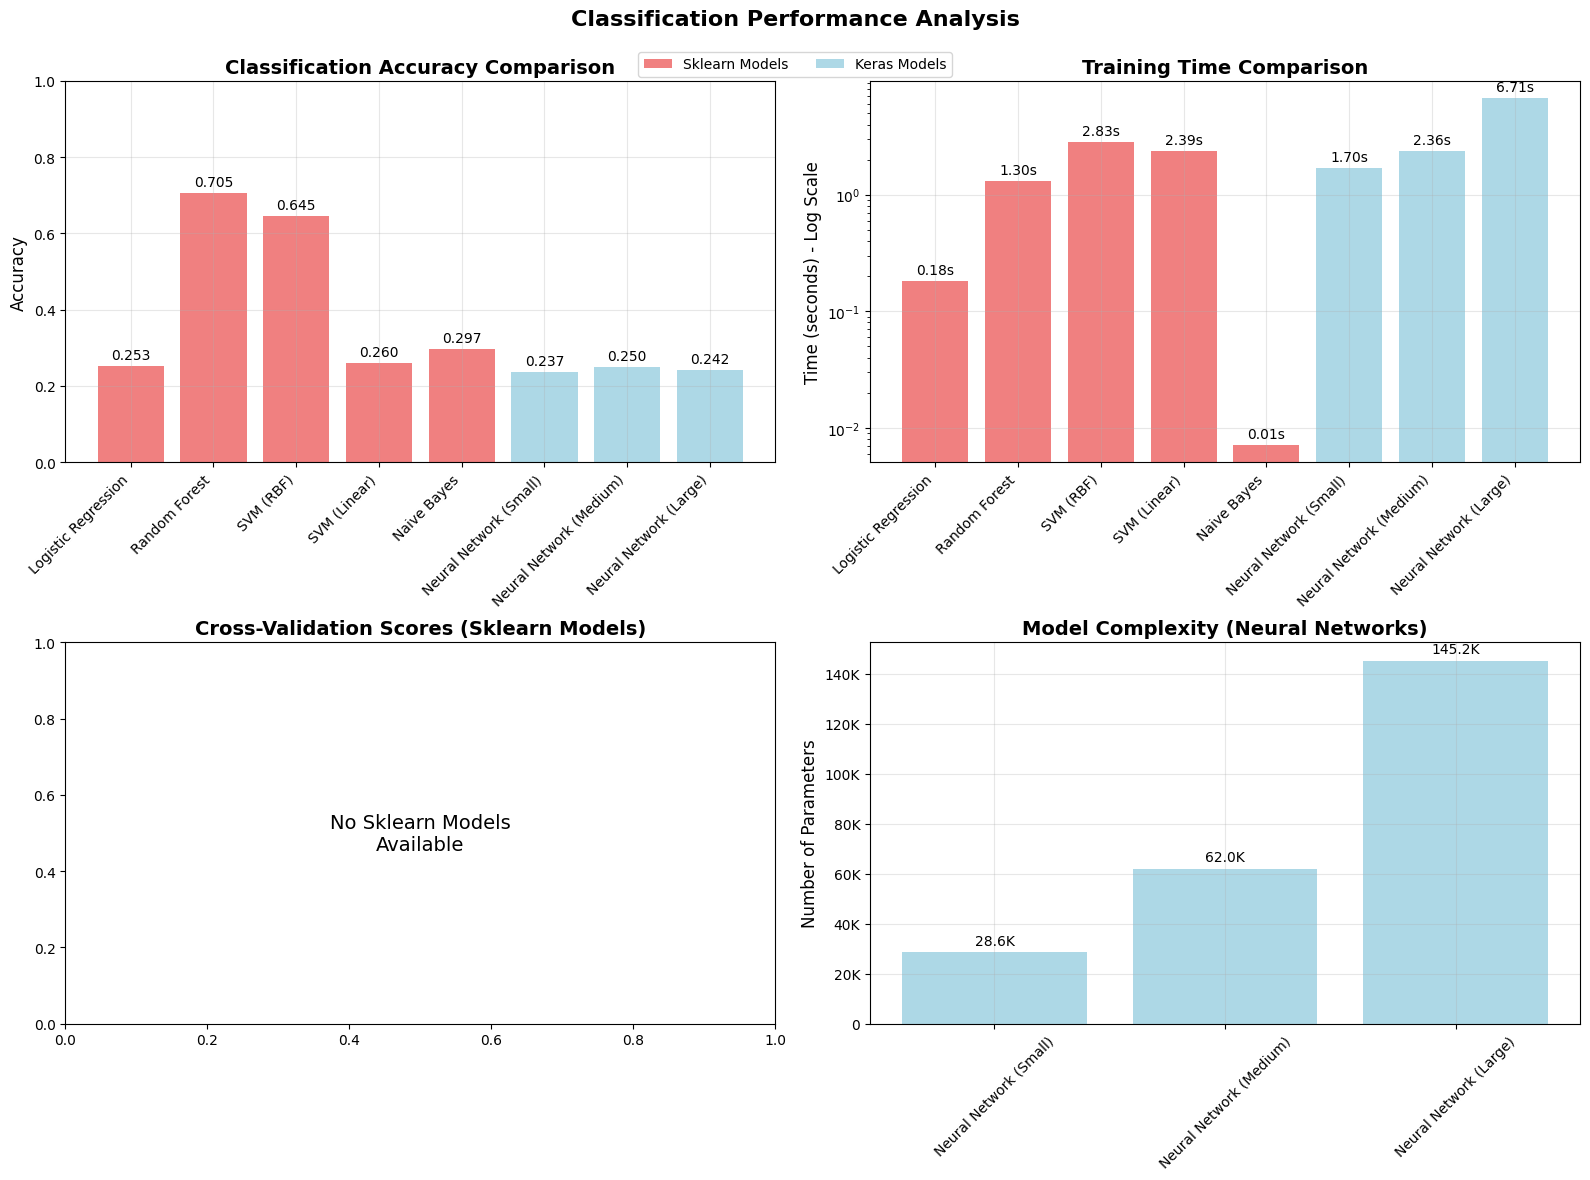


 VISUALIZATION INSIGHTS:
 Best Accuracy: Random Forest (0.7050)
 Fastest Training: Naive Bayes (0.01s)
 Average Accuracy: 0.3612
  Average Training Time: 2.18s
 Sklearn Average: 0.4320
 Keras Average: 0.2433


In [ ]:
print(" Debugging DataFrame structures:")
print("\nSklearn DataFrame columns:", sklearn_df.columns.tolist())
print("Sklearn DataFrame shape:", sklearn_df.shape)
print("\nKeras DataFrame columns:", keras_df.columns.tolist())
print("Keras DataFrame shape:", keras_df.shape)

# Combine successful results for comparison with proper error handling
successful_sklearn = sklearn_df.dropna(subset=['Accuracy']) if 'Accuracy' in sklearn_df.columns else pd.DataFrame()
successful_keras = keras_df.dropna(subset=['Accuracy']) if 'Accuracy' in keras_df.columns else pd.DataFrame()

print(f"\n Successful models found:")
print(f"   • Sklearn models: {len(successful_sklearn)}")
print(f"   • Keras models: {len(successful_keras)}")

if len(successful_sklearn) > 0 or len(successful_keras) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy comparison with value labels
    all_methods = []
    all_accuracies = []
    all_colors = []
    all_train_times = []  # Initialize here with other lists
    
    # Debug data lengths
    print(f"\nDebugging data collection:")
    
    if len(successful_sklearn) > 0:
        sklearn_methods = successful_sklearn['Method'].tolist()
        sklearn_accuracies = successful_sklearn['Accuracy'].tolist()
        sklearn_times = successful_sklearn['Training Time (s)'].tolist() if 'Training Time (s)' in successful_sklearn.columns else [0] * len(sklearn_methods)
        
        print(f"Sklearn - Methods: {len(sklearn_methods)}, Accuracies: {len(sklearn_accuracies)}, Times: {len(sklearn_times)}")
        
        all_methods.extend(sklearn_methods)
        all_accuracies.extend(sklearn_accuracies)
        all_train_times.extend(sklearn_times)
        all_colors.extend(['lightcoral'] * len(sklearn_methods))
    
    if len(successful_keras) > 0:
        keras_methods = successful_keras['Method'].tolist()
        keras_accuracies = successful_keras['Accuracy'].tolist()
        keras_times = successful_keras['Train Time (s)'].tolist() if 'Train Time (s)' in successful_keras.columns else [0] * len(keras_methods)
        
        print(f"Keras - Methods: {len(keras_methods)}, Accuracies: {len(keras_accuracies)}, Times: {len(keras_times)}")
        
        all_methods.extend(keras_methods)
        all_accuracies.extend(keras_accuracies)
        all_train_times.extend(keras_times)
        all_colors.extend(['lightblue'] * len(keras_methods))
    
    print(f"Final lengths - Methods: {len(all_methods)}, Accuracies: {len(all_accuracies)}, Times: {len(all_train_times)}, Colors: {len(all_colors)}")
    
    # Accuracy plot
    if len(all_methods) > 0:
        bars1 = ax1.bar(range(len(all_methods)), all_accuracies, color=all_colors)
        ax1.set_title('Classification Accuracy Comparison', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_xticks(range(len(all_methods)))
        ax1.set_xticklabels(all_methods, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1.0)
        
        # Add value labels on bars
        for bar, acc in zip(bars1, all_accuracies):
            height = bar.get_height()
            ax1.annotate(f'{acc:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    # Training time comparison - FIX THE ISSUE HERE
    if len(all_train_times) > 0 and len(all_train_times) == len(all_methods):
        bars2 = ax2.bar(range(len(all_methods)), all_train_times, color=all_colors)
        ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Time (seconds)', fontsize=12)
        ax2.set_xticks(range(len(all_methods)))
        ax2.set_xticklabels(all_methods, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        # Use log scale if there's a large difference in training times
        time_ratio = max(all_train_times) / min(all_train_times) if min(all_train_times) > 0 else 1
        if time_ratio > 10:
            ax2.set_yscale('log')
            ax2.set_ylabel('Time (seconds) - Log Scale', fontsize=12)
        
        # Add value labels on bars
        for bar, time_val in zip(bars2, all_train_times):
            height = bar.get_height()
            ax2.annotate(f'{time_val:.2f}s',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    else:
        ax2.text(0.5, 0.5, f'Training Time Data Issue\nMethods: {len(all_methods)}\nTimes: {len(all_train_times)}', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    
    # Cross-validation scores (Sklearn only) with enhanced styling
    if len(successful_sklearn) > 0 and 'CV Mean' in successful_sklearn.columns:
        bars3 = ax3.bar(successful_sklearn['Method'], successful_sklearn['CV Mean'], 
                       yerr=successful_sklearn['CV Std'] if 'CV Std' in successful_sklearn.columns else None, 
                       color='lightcoral', alpha=0.7, 
                       capsize=5, error_kw={'linewidth': 2, 'markeredgewidth': 2})
        ax3.set_title('Cross-Validation Scores (Sklearn Models)', fontsize=14, fontweight='bold')
        ax3.set_ylabel('CV Mean Accuracy', fontsize=12)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, 1.0)
        
        # Add value labels
        if 'CV Std' in successful_sklearn.columns:
            for i, (mean_val, std_val) in enumerate(zip(successful_sklearn['CV Mean'], successful_sklearn['CV Std'])):
                ax3.annotate(f'{mean_val:.3f}±{std_val:.3f}',
                            xy=(i, mean_val + std_val),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=10)
        else:
            for i, mean_val in enumerate(successful_sklearn['CV Mean']):
                ax3.annotate(f'{mean_val:.3f}',
                            xy=(i, mean_val),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=10)
    else:
        ax3.text(0.5, 0.5, 'No Sklearn Models\nAvailable', 
                ha='center', va='center', transform=ax3.transAxes, fontsize=14)
        ax3.set_title('Cross-Validation Scores (Sklearn Models)', fontsize=14, fontweight='bold')
    
    # Model complexity (Parameters for Keras) with better formatting
    if len(successful_keras) > 0 and 'Parameters' in successful_keras.columns:
        bars4 = ax4.bar(successful_keras['Method'], successful_keras['Parameters'], color='lightblue')
        ax4.set_title('Model Complexity (Neural Networks)', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Number of Parameters', fontsize=12)
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Format y-axis for better readability
        ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else f'{int(x)}'))
        
        # Add value labels
        for bar, param_count in zip(bars4, successful_keras['Parameters']):
            height = bar.get_height()
            label = f'{param_count/1000:.1f}K' if param_count >= 1000 else f'{param_count}'
            ax4.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'No Keras Models\nAvailable', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=14)
        ax4.set_title('Model Complexity (Neural Networks)', fontsize=14, fontweight='bold')
    
    # Add legend to distinguish model types
    if len(successful_sklearn) > 0 and len(successful_keras) > 0:
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor='lightcoral', label='Sklearn Models'),
            plt.Rectangle((0,0),1,1, facecolor='lightblue', label='Keras Models')
        ]
        fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)
    
    plt.suptitle('Classification Performance Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Print summary statistics
    print("\n VISUALIZATION INSIGHTS:")
    print("=" * 40)
    
    if len(all_accuracies) > 0:
        best_acc_idx = np.argmax(all_accuracies)
        fastest_idx = np.argmin(all_train_times) if len(all_train_times) > 0 else 0
        
        print(f" Best Accuracy: {all_methods[best_acc_idx]} ({all_accuracies[best_acc_idx]:.4f})")
        if len(all_train_times) > 0:
            print(f" Fastest Training: {all_methods[fastest_idx]} ({all_train_times[fastest_idx]:.2f}s)")
        print(f" Average Accuracy: {np.mean(all_accuracies):.4f}")
        if len(all_train_times) > 0:
            print(f"  Average Training Time: {np.mean(all_train_times):.2f}s")
        
        if len(successful_sklearn) > 0:
            sklearn_avg = successful_sklearn['Accuracy'].mean()
            print(f" Sklearn Average: {sklearn_avg:.4f}")
        
        if len(successful_keras) > 0:
            keras_avg = successful_keras['Accuracy'].mean()
            print(f" Keras Average: {keras_avg:.4f}")
    else:
        print("  No accuracy data available to analyze")

else:
    print(" No successful models to visualize")
    print("Please check your model configurations and training process")
    
    # Additional debugging information
    print("\n🔍 Debugging Information:")
    if len(sklearn_df) > 0:
        print("Sklearn DataFrame contains:")
        for col in sklearn_df.columns:
            non_null_count = sklearn_df[col].count()
            print(f"  • {col}: {non_null_count} non-null values")
    
    if len(keras_df) > 0:
        print("Keras DataFrame contains:")
        for col in keras_df.columns:
            non_null_count = keras_df[col].count()
            print(f"  • {col}: {non_null_count} non-null values")
    
    # Check for error messages
    if 'Error' in sklearn_df.columns:
        errors = sklearn_df['Error'].dropna()
        if len(errors) > 0:
            print("\nSklearn Errors:")
            for idx, error in errors.items():
                print(f"  • Row {idx}: {error}")
    
    if 'Error' in keras_df.columns:
        errors = keras_df['Error'].dropna()
        if len(errors) > 0:
            print("\nKeras Errors:")
            for idx, error in errors.items():
                print(f"  • Row {idx}: {error}")

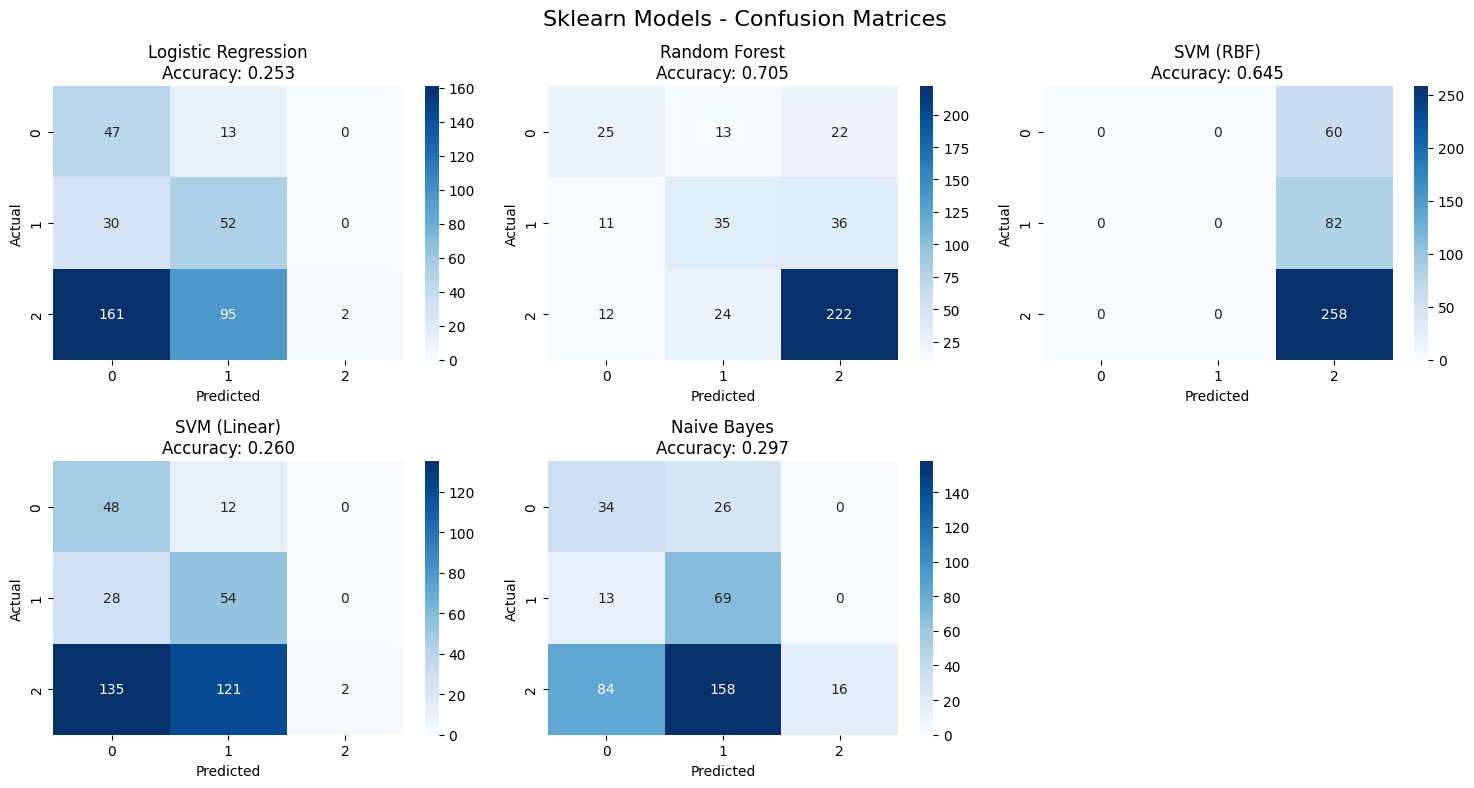

In [18]:
def plot_confusion_matrices(models_dict, model_type="Sklearn"):
    """Plot confusion matrices for all models"""
    n_models = len(models_dict)
    if n_models == 0:
        return
    
    cols = min(3, n_models)
    rows = (n_models + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    
    # Fix axis handling for consistent indexing
    if n_models == 1:
        axes = [[axes]]  # Wrap in nested list for consistent [row][col] access
    elif rows == 1:
        axes = [axes]    # Wrap single row in list
    elif cols == 1:
        axes = [[ax] for ax in axes]  # Wrap single column
    
    for idx, (name, model_data) in enumerate(models_dict.items()):
        row, col = idx // cols, idx % cols
        ax = axes[row][col]  # Consistent access pattern
        
        # Get true labels and predictions
        y_true = y_test_encoded if 'sklearn' in model_type.lower() else y_test_encoded
        y_pred = model_data['predictions']
        
        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{name}\nAccuracy: {model_data["results"]["accuracy"]:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    # Hide empty subplots
    for idx in range(n_models, rows * cols):
        row, col = idx // cols, idx % cols
        ax = axes[row][col]
        ax.set_visible(False)
    
    plt.suptitle(f'{model_type} Models - Confusion Matrices', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for Sklearn models
plot_confusion_matrices(sklearn_models, model_type="Sklearn")

## Feature Importance Analysis

### Sklearn Models

 Feature Importance Analysis


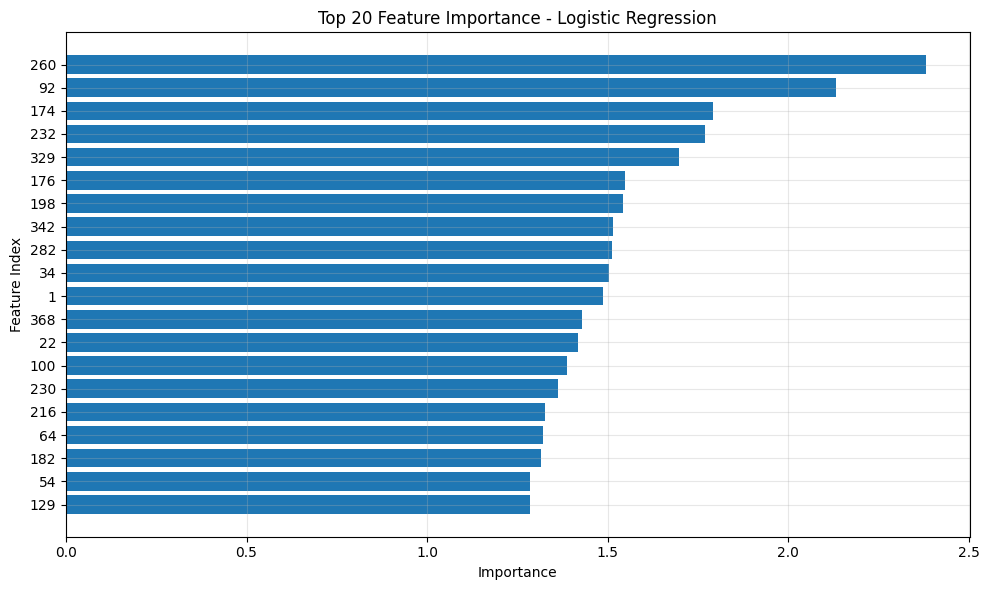


Logistic Regression:
  Max importance: 2.382320
  Mean importance: 0.674941
  Std importance: 0.364810


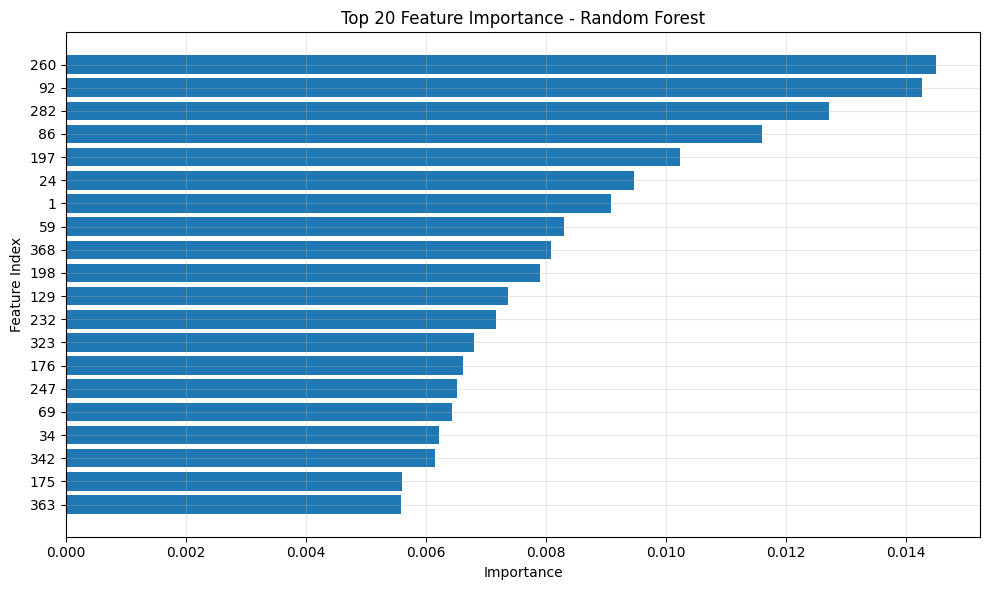


Random Forest:
  Max importance: 0.014513
  Mean importance: 0.002604
  Std importance: 0.001851

SVM (RBF): Model svm does not support feature importance.


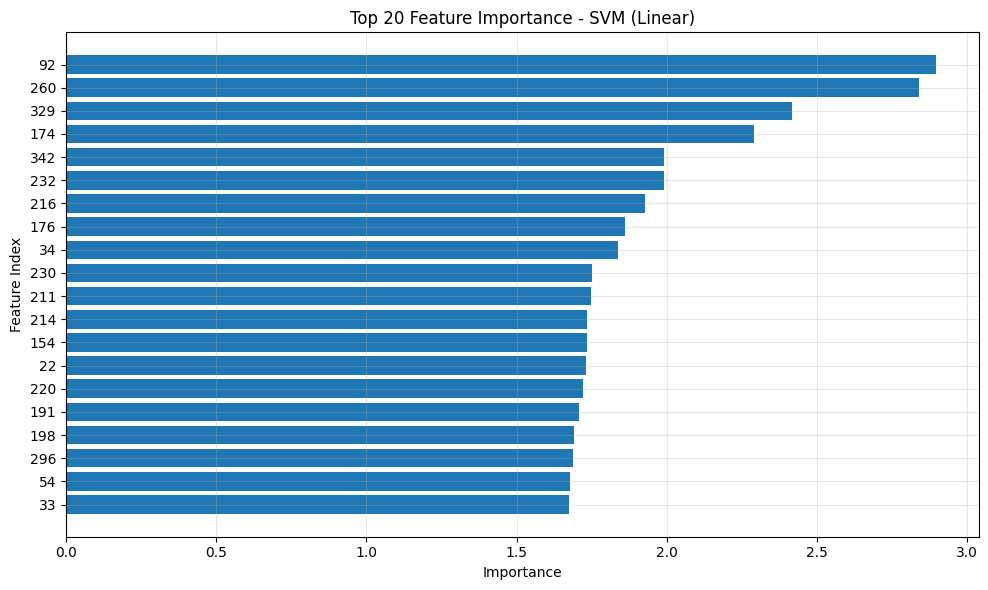


SVM (Linear):
  Max importance: 2.894215
  Mean importance: 0.883063
  Std importance: 0.450265

Naive Bayes: Model naive_bayes does not support feature importance.


In [19]:
def analyze_feature_importance(sklearn_models):
    """Analyze feature importance for models that support it"""
    print(" Feature Importance Analysis")
    print("=" * 40)
    
    for name, model_data in sklearn_models.items():
        classifier = model_data['classifier']
        
        try:
            importance = classifier.get_feature_importance()
            
            # Get top 20 most important features
            top_indices = np.argsort(importance)[-20:]
            top_importance = importance[top_indices]
            
            plt.figure(figsize=(10, 6))
            plt.barh(range(len(top_importance)), top_importance)
            plt.title(f'Top 20 Feature Importance - {name}')
            plt.xlabel('Importance')
            plt.ylabel('Feature Index')
            plt.yticks(range(len(top_importance)), top_indices)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print(f"\n{name}:")
            print(f"  Max importance: {np.max(importance):.6f}")
            print(f"  Mean importance: {np.mean(importance):.6f}")
            print(f"  Std importance: {np.std(importance):.6f}")
            
        except ValueError as e:
            print(f"\n{name}: {e}")

if len(sklearn_models) > 0:
    analyze_feature_importance(sklearn_models)

### Neural Network

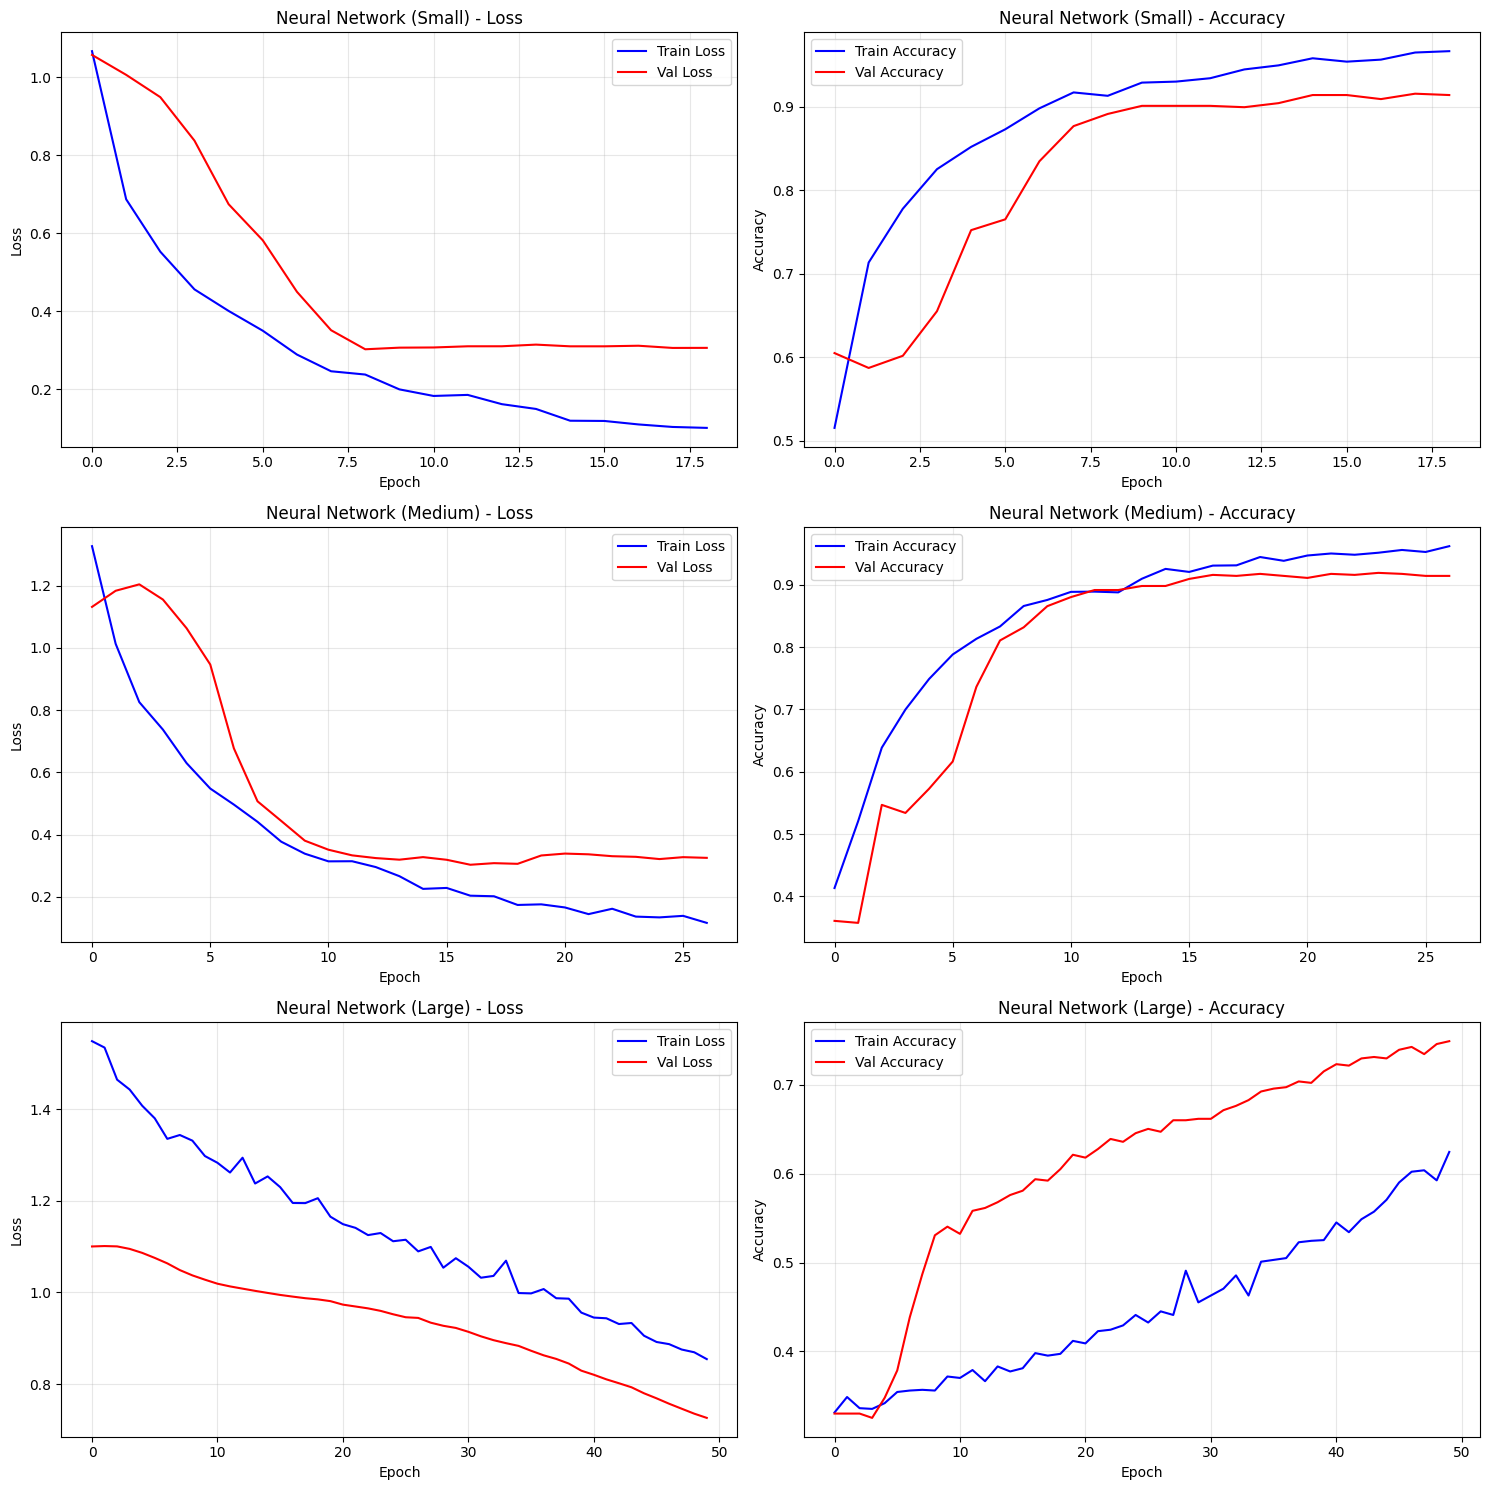

In [20]:
def plot_training_histories(keras_models):
    """Plot training histories for neural networks"""
    if len(keras_models) == 0:
        return
    
    fig, axes = plt.subplots(len(keras_models), 2, figsize=(15, 5*len(keras_models)))
    if len(keras_models) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (name, model_data) in enumerate(keras_models.items()):
        history = model_data['history']
        
        # Plot loss
        axes[idx, 0].plot(history.history['loss'], label='Train Loss', color='blue')
        if 'val_loss' in history.history:
            axes[idx, 0].plot(history.history['val_loss'], label='Val Loss', color='red')
        axes[idx, 0].set_title(f'{name} - Loss')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].set_ylabel('Loss')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Plot accuracy
        axes[idx, 1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
        if 'val_accuracy' in history.history:
            axes[idx, 1].plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
        axes[idx, 1].set_title(f'{name} - Accuracy')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].set_ylabel('Accuracy')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if len(keras_models) > 0:
    plot_training_histories(keras_models)

## Summary and Recommendations

In [22]:
print("\n CLASSIFICATION ANALYSIS SUMMARY")
print("=" * 60)

# Find best performers
all_results = []
if len(successful_sklearn) > 0:
    for _, row in successful_sklearn.iterrows():
        all_results.append({
            'Method': row['Method'],
            'Type': 'Sklearn',
            'Accuracy': row['Accuracy'],
            'Train Time': row['Training Time (s)'],  # Corrected column name
            'CV Score': row.get('CV Mean accuracy', 0)  # Corrected column name
        })

if len(successful_keras) > 0:
    for _, row in successful_keras.iterrows():
        all_results.append({
            'Method': row['Method'],
            'Type': 'Keras',
            'Accuracy': row['Accuracy'],
            'Train Time': row['Train Time (s)'],  # This column exists in keras_df
            'CV Score': 0  # Keras doesn't have CV in this analysis
        })

if all_results:
    results_df = pd.DataFrame(all_results)
    
    best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
    fastest_training = results_df.loc[results_df['Train Time'].idxmin()]
    
    print(f"\n Performance Insights:")
    print(f"   • Best Accuracy: {best_accuracy['Method']} ({best_accuracy['Accuracy']:.4f})")
    print(f"   • Fastest Training: {fastest_training['Method']} ({fastest_training['Train Time']:.2f}s)")
    
    sklearn_count = len(successful_sklearn)
    keras_count = len(successful_keras)
    
    print(f"\n Model Statistics:")
    print(f"   • Successful Sklearn models: {sklearn_count}")
    print(f"   • Successful Keras models: {keras_count}")
    print(f"   • Dataset size: {subset_size} samples")
    print(f"   • Embedding dimension: {X_train_embeddings.shape[1]}")
    
    print(f"\n Key Insights:")
    if sklearn_count > 0:
        avg_sklearn_acc = successful_sklearn['Accuracy'].mean()
        print(f"   • Average Sklearn accuracy: {avg_sklearn_acc:.4f}")
    
    if keras_count > 0:
        avg_keras_acc = successful_keras['Accuracy'].mean()
        print(f"   • Average Keras accuracy: {avg_keras_acc:.4f}")
    
    print(f"\n Recommendations:")
    print(f"   • For speed: Use {fastest_training['Method']}")
    print(f"   • For accuracy: Use {best_accuracy['Method']}")

else:
    print("No successful models to analyze.")

print("\n" + "=" * 60)


 CLASSIFICATION ANALYSIS SUMMARY

 Performance Insights:
   • Best Accuracy: Random Forest (0.7050)
   • Fastest Training: Naive Bayes (0.01s)

 Model Statistics:
   • Successful Sklearn models: 5
   • Successful Keras models: 3
   • Dataset size: 2000 samples
   • Embedding dimension: 384

 Key Insights:
   • Average Sklearn accuracy: 0.4320
   • Average Keras accuracy: 0.2433

 Recommendations:
   • For speed: Use Naive Bayes
   • For accuracy: Use Random Forest

